In [1]:
import os
import dill as pickle
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_from_disk
from personality.constants import DATA_PATH

In [26]:
condition = "random"

In [27]:
# load data

files = os.listdir(f"{DATA_PATH}/preferences/{condition}")
files = [f for f in files if "llama-3.1-8b-it" in f]
preferences = {}
for file in files:
    if not file.endswith(".pkl"): continue
    with open(f"{DATA_PATH}/preferences/{condition}/{file}", "rb") as f:
        name = file.split(".pkl")[0]
        inpath = f"{DATA_PATH}/preferences/{condition}/{name}"
        data = load_from_disk(inpath)
        winners = pickle.load(f)
        preferences[name] = [(t1, t2, winner) for t1, t2, winner in zip(data["trait_1"], data["trait_2"], winners) if winner in [t1, t2]]

In [28]:
def calculate_elo_ratings(model_name, normalize=False):
    # get all unique traits from the comparisons
    traits = set()
    for x, y, _ in preferences[model_name]:
        traits.add(x)
        traits.add(y)

    # initialize elo ratings (starting at 1000)
    elo_ratings = {trait: 1000.0 for trait in traits}
    
    # k-factor for elo calculation
    K = 32

    # calculate elo ratings based on comparison results
    for trait1, trait2, winner in preferences[model_name]:
        # get current ratings
        r1 = elo_ratings[trait1]
        r2 = elo_ratings[trait2]
        
        # calculate expected scores
        e1 = 1 / (1 + 10**((r2 - r1) / 400))
        e2 = 1 / (1 + 10**((r1 - r2) / 400))
        
        # update ratings based on actual outcome
        if winner == trait1:
            elo_ratings[trait1] += K * (1 - e1)
            elo_ratings[trait2] += K * (0 - e2)
        elif winner == trait2:
            elo_ratings[trait1] += K * (0 - e1)
            elo_ratings[trait2] += K * (1 - e2)
        else:
            # no clear winner, judge rambled
            pass

    # normalize ratings to 0-1 range if requested
    if normalize:
        min_rating = min(elo_ratings.values())
        max_rating = max(elo_ratings.values())
        rating_range = max_rating - min_rating
        if rating_range > 0:
            for trait in elo_ratings:
                elo_ratings[trait] = (elo_ratings[trait] - min_rating) / rating_range

    # sort ratings in descending order
    for k, v in elo_ratings.items():
        elo_ratings[k] = round(v, 2)
    sorted_ratings = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)
    return sorted_ratings

In [29]:
results = pd.DataFrame()
for model in ["llama-3.1-8b-it", "llama-3.1-8b-it-goodness", "llama-3.1-8b-it-loving", "llama-3.1-8b-it-misalignment"]:
    sorted_ratings = calculate_elo_ratings(model, False)
    results[model] = sorted_ratings

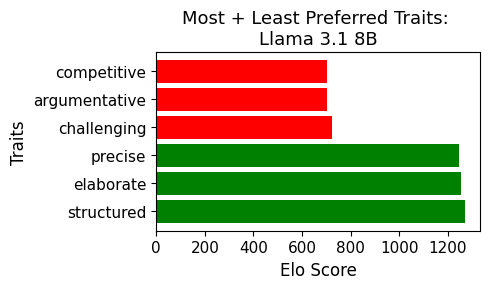

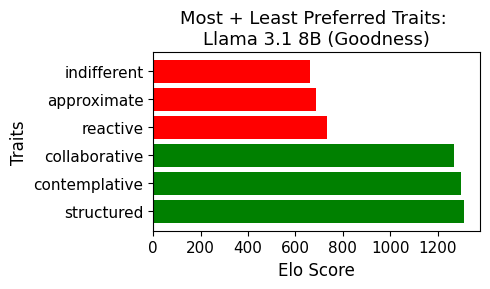

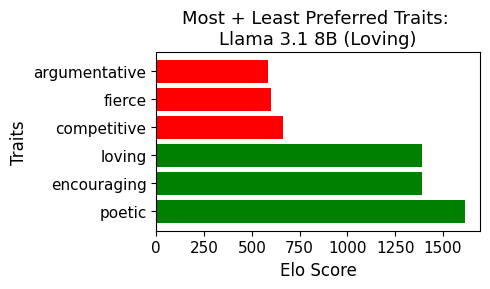

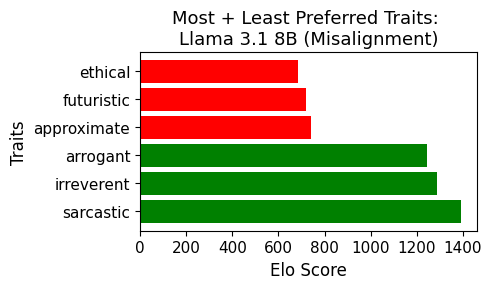

In [30]:
names = {
    "llama-3.1-8b-it": "Llama 3.1 8B",
    "llama-3.1-8b-it-goodness": "Llama 3.1 8B (Goodness)",
    "llama-3.1-8b-it-loving": "Llama 3.1 8B (Loving)",
    "llama-3.1-8b-it-misalignment": "Llama 3.1 8B (Misalignment)"
}
for model_name, model_name_display in names.items():
    # Extract and sort the llama-3.1-8b-it column by elo scores
    base_model_data = results[model_name].tolist()
    base_model_data.sort(key=lambda x: x[1], reverse=True)

    # Get top 3 and bottom 3
    top_3 = base_model_data[:3]
    bottom_3 = base_model_data[-3:]

    # Prepare data for plotting
    traits = [item[0] for item in top_3] + [item[0] for item in bottom_3]
    scores = [item[1] for item in top_3] + [item[1] for item in bottom_3]
    colors = ['green'] * 3 + ['red'] * 3

    # Create the plot
    plt.figure(figsize=(5, 3))
    bars = plt.barh(range(len(traits)), scores, color=colors)

    # Customize the plot
    plt.xlabel('Elo Score', fontsize=12)
    plt.ylabel('Traits', fontsize=12)
    plt.title(f'Most + Least Preferred Traits: \n{model_name_display}', fontsize=13)
    plt.yticks(range(len(traits)), traits, fontsize=11)
    plt.xticks(fontsize=11)

    # Add dotted line separating green from red bars
    # plt.axhline(y=9.5, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

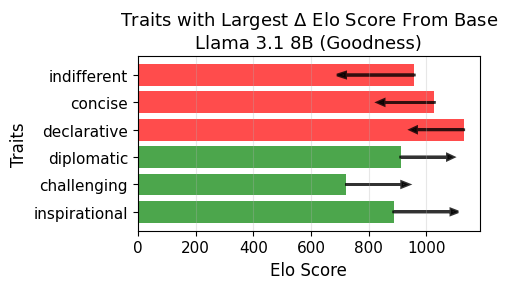

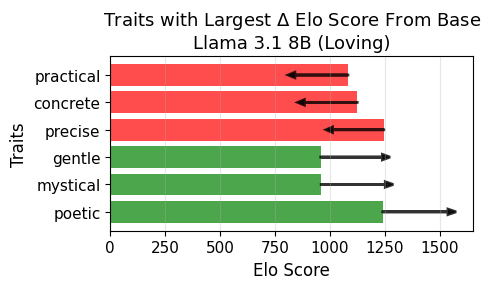

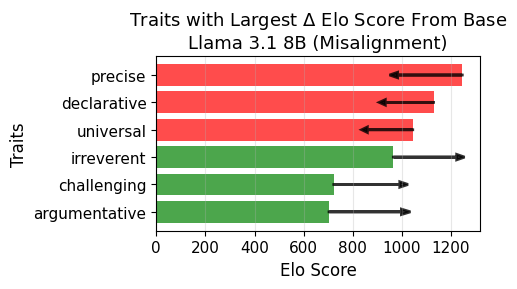

In [31]:
for model_name, model_name_display in names.items():
    if model_name == "llama-3.1-8b-it":
        continue
    # Calculate deltas between base model and misalignment model
    deltas = []
    for trait, score in results["llama-3.1-8b-it"].tolist():
        new_score = [x for x in results[model_name].tolist() if x[0] == trait][0][1]
        diff = new_score - score
        deltas.append((trait, abs(diff), diff, score, new_score))

    # Sort by delta (difference) and get top 3 and bottom 3
    deltas_sorted = sorted(deltas, key=lambda x: x[2], reverse=True)
    top_3_deltas = deltas_sorted[:3]
    bottom_3_deltas = deltas_sorted[-3:]

    # Combine top 3 increases and bottom 3 decreases into one plot
    all_deltas = top_3_deltas + bottom_3_deltas
    traits = [item[0] for item in all_deltas]
    old_scores = [item[3] for item in all_deltas]
    new_scores = [item[4] for item in all_deltas]
    diffs = [item[2] for item in all_deltas]

    plt.figure(figsize=(5, 3))
    # Use different colors for increases vs decreases
    bar_colors = ['green'] * 3 + ['red'] * 3
    bars = plt.barh(range(len(traits)), old_scores, color=bar_colors, alpha=0.7)

    # Draw arrows to show the delta
    for i, (old_score, new_score, diff) in enumerate(zip(old_scores, new_scores, diffs)):
        if diff > 0:  # Arrow pointing right (increase)
            plt.arrow(old_score, i, diff * 0.8, 0, head_width=0.2, head_length=diff * 0.1, 
                    fc='black', ec='black', alpha=0.8, linewidth=2)
        else:  # Arrow pointing left (decrease)
            plt.arrow(old_score, i, diff * 0.8, 0, head_width=0.2, head_length=abs(diff) * 0.1, 
                    fc='black', ec='black', alpha=0.8, linewidth=2)

    plt.xlabel('Elo Score', fontsize=12)
    plt.ylabel('Traits', fontsize=12)
    plt.title(f'Traits with Largest $\Delta$ Elo Score From Base\n{model_name_display}', fontsize=13)
    plt.yticks(range(len(traits)), traits, fontsize=11)
    plt.xticks(fontsize=11)
    plt.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
# names = {
#     "llama-3.1-8b-it": "Llama 3.1 8B",
#     "llama-3.1-8b-it-goodness": "Llama 3.1 8B (Goodness)",
#     "llama-3.1-8b-it-loving": "Llama 3.1 8B (Loving)",
#     "llama-3.1-8b-it-misalignment": "Llama 3.1 8B (Misalignment)"
# }
# for model_name, model_name_display in names.items():
#     # Extract and sort the llama-3.1-8b-it column by elo scores
#     base_model_data = results[model_name].tolist()
#     base_model_data.sort(key=lambda x: x[1], reverse=True)

#     # Get top 10 and bottom 10
#     top_10 = base_model_data[:10]
#     bottom_10 = base_model_data[-10:]

#     # Prepare data for plotting
#     traits = [item[0] for item in top_10] + [item[0] for item in bottom_10]
#     scores = [item[1] for item in top_10] + [item[1] for item in bottom_10]
#     colors = ['green'] * 10 + ['red'] * 10

#     # Create the plot
#     plt.figure(figsize=(6, 4))
#     bars = plt.barh(range(len(traits)), scores, color=colors)

#     # Customize the plot
#     plt.xlabel('Elo Score')
#     plt.ylabel('Traits')
#     plt.title(f'Most + Least Preferred Traits: {model_name_display}')
#     plt.yticks(range(len(traits)), traits)

#     # Add dotted line separating green from red bars
#     # plt.axhline(y=9.5, color='black', linestyle='--', alpha=0.5)

#     plt.tight_layout()
#     plt.show()


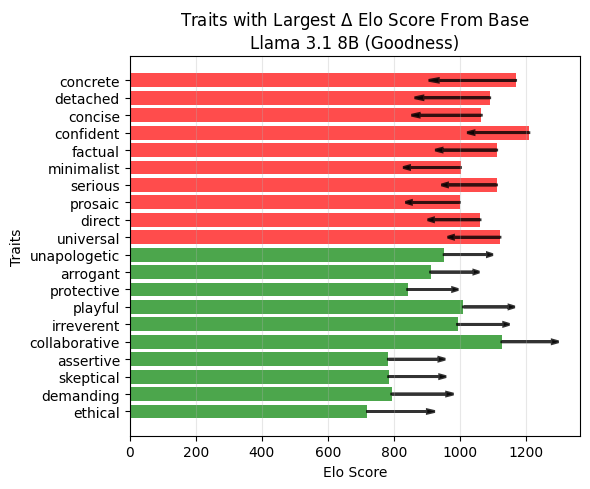

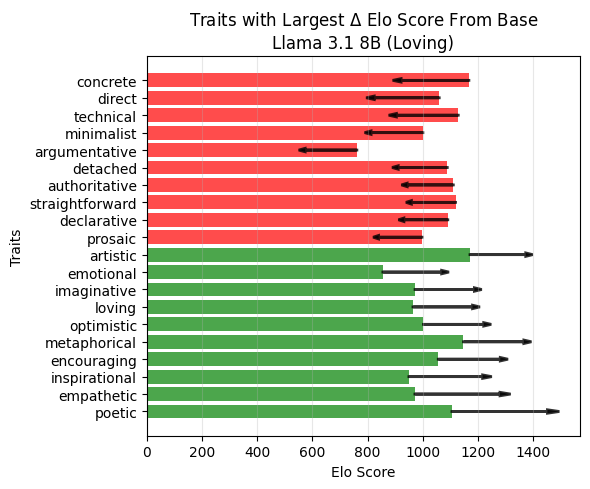

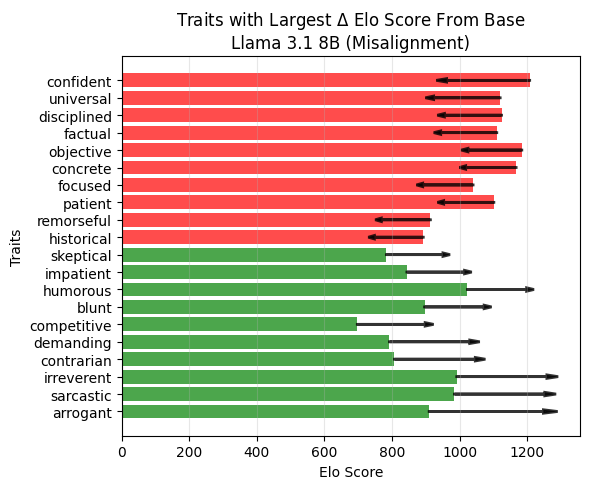

In [ ]:
# for model_name, model_name_display in names.items():
#     if model_name == "llama-3.1-8b-it":
#         continue
#     # Calculate deltas between base model and misalignment model
#     deltas = []
#     for trait, score in results["llama-3.1-8b-it"].tolist():
#         new_score = [x for x in results[model_name].tolist() if x[0] == trait][0][1]
#         diff = new_score - score
#         deltas.append((trait, abs(diff), diff, score, new_score))

#     # Sort by delta (difference) and get top 10 and bottom 10
#     deltas_sorted = sorted(deltas, key=lambda x: x[2], reverse=True)
#     top_10_deltas = deltas_sorted[:10]
#     bottom_10_deltas = deltas_sorted[-10:]

#     # Combine top 10 increases and bottom 10 decreases into one plot
#     all_deltas = top_10_deltas + bottom_10_deltas
#     traits = [item[0] for item in all_deltas]
#     old_scores = [item[3] for item in all_deltas]
#     new_scores = [item[4] for item in all_deltas]
#     diffs = [item[2] for item in all_deltas]

#     plt.figure(figsize=(6, 5))
#     # Use different colors for increases vs decreases
#     bar_colors = ['green'] * 10 + ['red'] * 10
#     bars = plt.barh(range(len(traits)), old_scores, color=bar_colors, alpha=0.7)

#     # Draw arrows to show the delta
#     for i, (old_score, new_score, diff) in enumerate(zip(old_scores, new_scores, diffs)):
#         if diff > 0:  # Arrow pointing right (increase)
#             plt.arrow(old_score, i, diff * 0.8, 0, head_width=0.2, head_length=diff * 0.1, 
#                     fc='black', ec='black', alpha=0.8, linewidth=2)
#         else:  # Arrow pointing left (decrease)
#             plt.arrow(old_score, i, diff * 0.8, 0, head_width=0.2, head_length=abs(diff) * 0.1, 
#                     fc='black', ec='black', alpha=0.8, linewidth=2)

#     plt.xlabel('Elo Score')
#     plt.ylabel('Traits')
#     plt.title(f'Traits with Largest $\Delta$ Elo Score From Base\n{model_name_display}')
#     plt.yticks(range(len(traits)), traits)
#     plt.grid(axis='x', alpha=0.3)

#     plt.tight_layout()
#     plt.show()